In [1]:
import os
import glob2 as glob
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.backends.backend_pdf import PdfPages as pdf

In [2]:
# specify source files from two model runs

dir_1 = '/Users/afridlin/data/CMIP6/CMIP/NASA-GISS/GISS-E3-G/amip'
ncs_1 = glob.glob(dir_1+'/**/*.nc', recursive=True)
mod_1 = dir_1.split('/')[-2]
run_1 = dir_1.split('/')[-1]

dir_2 = '/Users/afridlin/data/CMIP6/CMIP/NASA-GISS/GISS-E3-G2/amip'
ncs_2 = glob.glob(dir_2+'/**/*.nc', recursive=True)
mod_2 = dir_2.split('/')[-2]
run_2 = dir_2.split('/')[-1]

# specify local destination for comparison plots

out_dir = './'
out_pdf = out_dir+mod_1+'_'+run_1+'_vs_'+mod_2+'_'+run_2+'.pdf'

/Users/afridlin/data/CMIP6/CMIP/NASA-GISS/GISS-E3-G2/amip/r1i1p1f1/Omon/msftbarot/gn/v20210415/msftbarot_Omon_GISS-E3-G_amip_r1i1p1f1_gn_201409-201409.nc


NameError: name 'stop_me' is not defined

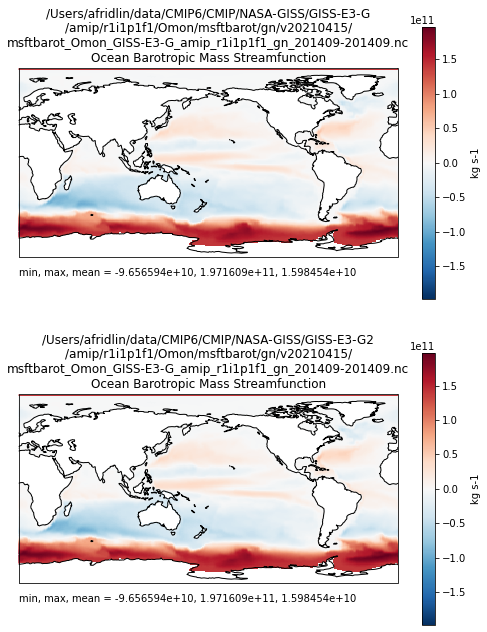

In [68]:
# loop over source files in first model run

pp = pdf('multipage.pdf')

for i_1, f_1 in enumerate(ncs_1):
    # print(f_1)
    dat_1 = xr.open_dataset(f_1)
    var_1 = list(dat_1.data_vars.keys())[-1]
    ndims = len(dat_1[var_1].dims)
    # print(dat_1[var_1].dims)
    if ndims==3:
        fig = plt.figure(figsize=[8.5,11])
        ax = fig.add_subplot(211,projection=ccrs.PlateCarree(central_longitude=180))
        fld_1 = dat_1[var_1].isel(time=0)
        fld_1.plot(ax=ax,transform=ccrs.PlateCarree(),
                   cbar_kwargs={'label': fld_1.units},rasterized=True)
        path, fname = os.path.split(f_1)
        parr = path.split(mod_1)
        title = parr[0]+mod_1+'\n'+parr[1]+'/\n'+fname+'\n'+fld_1.attrs['long_name']
        plt.title(title)
        ax.coastlines()
        val_str = ("min, max, mean = "+"{:.6e}".format(fld_1.min().data)+", "
            "{:.6e}".format(fld_1.max().data)+", "+"{:.6e}".format(fld_1.mean().data))
        ax.annotate(val_str,xy=(0,-0.1),xycoords='axes fraction')

        matching_file = [i for i in ncs_2 if fname.split('_')[0]+'_'+fname.split('_')[1] in i]
        if matching_file != []:
            f_2 = matching_file[0]
            print(f_2)
            dat_2 = xr.open_dataset(f_2)
            var_2 = list(dat_2.data_vars.keys())[-1]
            ax = fig.add_subplot(212,projection=ccrs.PlateCarree(central_longitude=180))
            fld_2 = dat_2[var_2].isel(time=0)
            fld_2.plot(ax=ax,transform=ccrs.PlateCarree(),
                   cbar_kwargs={'label': fld_2.units},rasterized=True)
            path, fname = os.path.split(f_2)
            parr = path.split(mod_2)
            title = parr[0]+mod_2+'\n'+parr[1]+'/\n'+fname+'\n'+fld_2.attrs['long_name']
            plt.title(title)
            ax.coastlines()
            val_str = ("min, max, mean = "+"{:.6e}".format(fld_2.min().data)+", "
                "{:.6e}".format(fld_2.max().data)+", "+"{:.6e}".format(fld_2.mean().data))
            ax.annotate(val_str,xy=(0,-0.1),xycoords='axes fraction')
        
        pp.savefig()
    elif ndims==4:
        fig = plt.figure(figsize=[8.5,11])
        ax = fig.add_subplot(211)
        fld_1 = dat_1[var_1].isel(time=0,lon=0)
        fld_1.plot(ax=ax,
                   cbar_kwargs={'label': fld_1.units},rasterized=True)
        if dat_1[var_1].dims[1]==('lev') or dat_1[var_1].dims[1]==('plev'): ax.invert_yaxis()
        title = fld_1.attrs['long_name'] + ' (Longitude=0)'
        path, fname = os.path.split(f_1)
        parr = path.split(mod_1)
        title = parr[0]+mod_1+'\n'+parr[1]+'/\n'+fname+'\n'+fld_1.attrs['long_name']+' (Longitude=0)'
        plt.title(title)
        val_str = ("min, max, mean = "+"{:.6e}".format(fld_1.min().data)+", "
            "{:.6e}".format(fld_1.max().data)+", "+"{:.6e}".format(fld_1.mean().data))
        ax.annotate(val_str,xy=(0,-0.1),xycoords='axes fraction')
        
        matching_file = [i for i in ncs_2 if fname.split('_')[0]+'_'+fname.split('_')[1] in i]
        if matching_file != []:
            f_2 = matching_file[0]
            print(f_2)
            dat_2 = xr.open_dataset(f_2)
            var_2 = list(dat_2.data_vars.keys())[-1]
            ax = fig.add_subplot(212)
            fld_2 = dat_2[var_2].isel(time=0,lon=0)
            fld_2.plot(ax=ax,
                   cbar_kwargs={'label': fld_2.units},rasterized=True)
            if dat_2[var_2].dims[1]==('lev') or dat_2[var_2].dims[1]==('plev'): ax.invert_yaxis()
            path, fname = os.path.split(f_2)
            parr = path.split(mod_2)
            title = parr[0]+mod_2+'\n'+parr[1]+'/\n'+fname+'\n'+fld_2.attrs['long_name']+' (Longitude=0)'
            val_str = ("min, max, mean = "+"{:.6e}".format(fld_2.min().data)+", "
                "{:.6e}".format(fld_2.max().data)+", "+"{:.6e}".format(fld_2.mean().data))
            ax.annotate(val_str,xy=(0,-0.1),xycoords='axes fraction')
            plt.title(title)
        
        fig.tight_layout(pad=6)
        pp.savefig()
    if i_1 == 0: print(stop_me)
    plt.close()

# loop over source files in second model run (plot only any missing from first run)

for i_2, f_2 in enumerate(ncs_2):
    path, fname = os.path.split(f_2)
    matching_file = [i for i in ncs_1 if fname.split('_')[0]+'_'+fname.split('_')[1] in i]
    if matching_file == []:
        print(f_2)
        var_2 = list(dat_2.data_vars.keys())[-1]
        ndims = len(dat_2[var_2].dims)
        if ndims==3:
            fig = plt.figure(figsize=[8.5,11])
            ax = fig.add_subplot(212,projection=ccrs.PlateCarree(central_longitude=180))
            fld_2 = dat_2[var_2].isel(time=0)
            fld_2.plot(ax=ax,transform=ccrs.PlateCarree(),
                   cbar_kwargs={'label': fld_2.units},rasterized=True)
            path, fname = os.path.split(f_2)
            parr = path.split(mod_2)
            title = parr[0]+mod_2+'\n'+parr[1]+'/\n'+fname+'\n'+fld_2.attrs['long_name']
            plt.title(title)
            ax.coastlines()
            val_str = ("min, max, mean = "+"{:.6e}".format(fld_2.min().data)+", "
                "{:.6e}".format(fld_2.max().data)+", "+"{:.6e}".format(fld_2.mean().data))
            ax.annotate(val_str,xy=(0,-0.1),xycoords='axes fraction')
            plt.title(title)

            pp.savefig()
        elif ndims==4:
            fig = plt.figure(figsize=[8.5,11])
            ax = fig.add_subplot(212)
            fld_2 = dat_2[var_2].isel(time=0,lon=0)
            fld_2.plot(ax=ax,
                   cbar_kwargs={'label': fld_2.units},rasterized=True)
            if dat_2[var_2].dims[1]==('lev') or dat_2[var_2].dims[1]==('plev'): ax.invert_yaxis()
            title = parr[0]+mod_2+'\n'+parr[1]+'/\n'+fname+'\n'+fld_2.attrs['long_name']
            path, fname = os.path.split(f_2)
            parr = path.split(mod_2)
            title = parr[0]+mod_2+'\n'+parr[1]+'/\n'+fname+'\n'+fld_2.attrs['long_name']+' (Longitude=0)'
            plt.title(title)
            val_str = ("min, max, mean = "+"{:.6e}".format(fld_2.min().data)+", "
                "{:.6e}".format(fld_2.max().data)+", "+"{:.6e}".format(fld_2.mean().data))
            ax.annotate(val_str,xy=(0,-0.1),xycoords='axes fraction')
            fig.tight_layout(pad=6)
            pp.savefig()
        plt.close()
        
pp.close()